# Zillow Prize Challenge data analysis

Author: Giovanni Costa

# Introduction

The real estate market in the United States has been transformed by the advent of advanced machine learning technologies, particularly through Zillow’s "Zestimate" home valuation system. Since its introduction 11 years ago, Zestimate has provided consumers with a valuable tool to estimate home values using millions of statistical and machine learning models that analyze hundreds of data points on individual properties. The accuracy of these estimates has improved significantly over time, with the median margin of error reduced from 14% to 5%, establishing Zillow as a leading real estate marketplace.

The Zillow Prize competition, offering a one million dollar grand prize, aims to further enhance the accuracy of Zestimate by challenging data scientists to develop new models for home value prediction. This competition holds significant potential, as the winning models will influence the estimated values of over 110 million homes across the U.S., directly impacting homeowners and buyers alike.

In this report, a predictive model for house price estimation is developed with a strong emphasis on precision. The dataset underwent extensive preprocessing, including meticulous feature handling, missing value imputation, and data cleaning. A machine learning tree-based approach was selected, not only due to its strong performance but also because of its high interpretability. The resulting model demonstrates a robust predictive capability, offering valuable insights into the factors influencing home prices.

In [1]:
# Library imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, random, joblib, os, sys
import xgboost as xgb
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV

sys.path.insert(0, "..")
from utils.general_utils import *

# Set up the working directory
INPUT_DATA_DIR = "../data/input"
OUTPUT_DATA_DIR = "../data/output"
MODEL_DIR = "../models"
PROPS_FILENAME = "properties_2016.parquet"
TRAIN_DATA_FILENAME = "train_2016_v2.csv"
PROPS_PATH = os.path.join(INPUT_DATA_DIR, PROPS_FILENAME)
TRAIN_DATA_PATH = os.path.join(INPUT_DATA_DIR, TRAIN_DATA_FILENAME)
SEED = 42
TOP_K_DISPLAY = 20
CV_ITER = 5
RANDOM_SEARCH_ITER = 10

# Set up the random seed
np.random.seed(SEED)
random.seed(SEED)
# Display options
pd.options.display.float_format = "{:.4f}".format

<a id="overview"></a>
# Dataset overview

## Train data

In [2]:
df_train = pd.read_csv(
    TRAIN_DATA_PATH, parse_dates=["transactiondate"], date_format="%Y-%m-%d"
)
df_train[df_train.select_dtypes(np.float64).columns] = df_train.select_dtypes(
    np.float64
).astype(np.float32)
df_train.info(max_cols=TOP_K_DISPLAY)
print("Shape: ", df_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   parcelid         90275 non-null  int64         
 1   logerror         90275 non-null  float32       
 2   transactiondate  90275 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int64(1)
memory usage: 1.7 MB
Shape:  (90275, 3)


In [3]:
# Missing value ratio
df_train.isna().sum() / df_train.shape[0] * 100

parcelid          0.0000
logerror          0.0000
transactiondate   0.0000
dtype: float64

In [4]:
print("Duplicated rows: ", df_train[["parcelid", "transactiondate"]].duplicated().sum())
print("Duplicated parcelid: ", df_train["parcelid"].duplicated().sum())

Duplicated rows:  0
Duplicated parcelid:  125


The dataset contains 3 columns:
- Parcelid: unique ID that identifies each building instance
- Logerror: index that it's useed to verify the goodness of the model<br>
From the competition website: "Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as $$logerror=log(Zestimate)−log( SalePrice)$$
- Transactiondate: Sale date for that building instance

Also there are no null values ​​in the dataset but there are duplicate parcelids, even though the parcelid and transactiondate pair is unique for each row. This implies that there are actual (or forecasted) sales data for the same building on different days

## Properties data

In [5]:
df_prop = pd.DataFrame([])
if PROPS_PATH.endswith(".csv"):
    df_prop = pd.read_csv(PROPS_PATH)
    to_float64_float32(df_prop)
    df_prop.to_parquet(
        os.path.join(INPUT_DATA_DIR, PROPS_FILENAME.split(".")[0] + ".parquet")
    )
else:
    df_prop = pd.read_parquet(PROPS_PATH)

# df_prop=pd.read_csv(input_folder+data_file_name, header=0) #parameter nrows=x to limit the number of rows

df_prop.info(max_cols=TOP_K_DISPLAY)
print("Shape: ", df_prop.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Columns: 58 entries, parcelid to censustractandblock
dtypes: float32(52), int64(1), object(5)
memory usage: 728.8+ MB
Shape:  (2985217, 58)


In [6]:
# Missing value ratio
df_prop.isna().sum().sort_values(ascending=False)[:TOP_K_DISPLAY] / df_prop.shape[
    0
] * 100

storytypeid                99.9456
basementsqft               99.9455
yardbuildingsqft26         99.9113
fireplaceflag              99.8270
architecturalstyletypeid   99.7970
typeconstructiontypeid     99.7740
finishedsquarefeet13       99.7430
buildingclasstypeid        99.5769
decktypeid                 99.4273
finishedsquarefeet6        99.2630
poolsizesum                99.0634
pooltypeid2                98.9255
pooltypeid10               98.7626
taxdelinquencyflag         98.1086
taxdelinquencyyear         98.1085
hashottuborspa             97.6881
yardbuildingsqft17         97.3082
finishedsquarefeet15       93.6086
finishedfloor1squarefeet   93.2093
finishedsquarefeet50       93.2093
dtype: float64

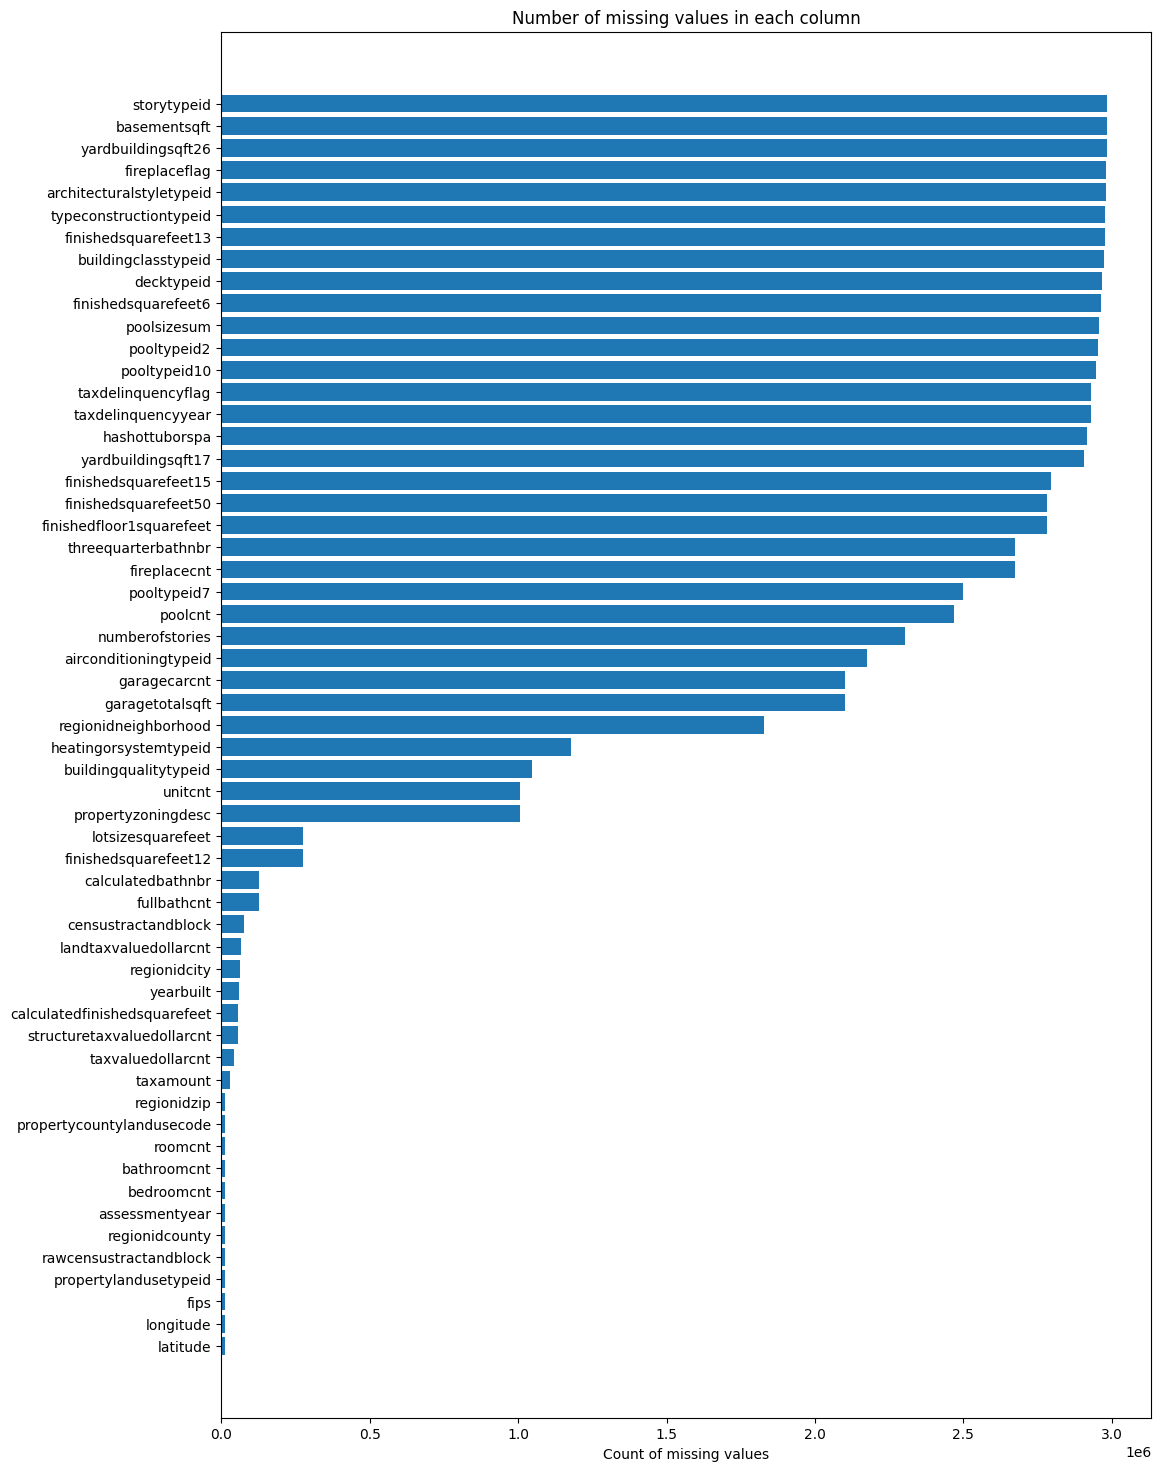

In [7]:
# Missing values ​​plot
df_missing = df_prop.isnull().sum(axis=0).reset_index()
df_missing.columns = ["column_name", "missing_count"]
df_missing = df_missing.loc[df_missing["missing_count"] > 0]
df_missing = df_missing.sort_values(by="missing_count")

ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(12, 18))
rects = ax.barh(ind, df_missing["missing_count"])
ax.set_yticks(ind)
ax.set_yticklabels(df_missing["column_name"], rotation="horizontal")
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()
del df_missing

In [8]:
# Columns containing categorical variables based on the documentation provided on kaggle.com (used later)
other_cols = [
    "parcelid",
    "airconditioningtypeid",
    "architecturalstyletypeid",
    "buildingqualitytypeid",
    "buildingclasstypeid",
    "decktypeid",
    "fips",
    "fireplaceflag",
    "hashottuborspa",
    "heatingorsystemtypeid",
    "pooltypeid10",
    "pooltypeid2",
    "pooltypeid7",
    "propertycountylandusecode",
    "propertylandusetypeid",
    "propertyzoningdesc",
    "rawcensustractandblock",
    "censustractandblock",
    "regionidcounty",
    "regionidcity",
    "regionidzip",
    "regionidneighborhood",
    "regionidzip",
    "storytypeid",
    "typeconstructiontypeid",
    "assessmentyear",
    "taxdelinquencyflag",
    "taxdelinquencyyear",
    "yearbuilt",
]
numerical_cols = [x for x in df_prop.columns if x not in other_cols]

In [9]:
# Displaying column values ​​of non-float, int, or datetime type
not_float_col = df_prop.select_dtypes(exclude=[np.float32, np.int64]).columns
for c in not_float_col:
    print("Column: " + c)
    print("values: ", df_prop[c].unique()[:TOP_K_DISPLAY], "\n")

Column: hashottuborspa
values:  [None True] 

Column: propertycountylandusecode
values:  ['010D' '0109' '1200' '1210' '010V' '300V' '0100' '0200' '010C' '0300'
 '1204' '100V' '01HC' '120C' '040V' '1214' '0101' None '070P' '0700'] 

Column: propertyzoningdesc
values:  [None 'LCA11*' 'LAC2' 'LAM1' 'LAC4' 'BUC4YY' 'BUR1*' 'SFC2*' 'SCUR3'
 'LCA25*' 'SCBP' 'PDA1*' 'PDA21*' 'LCA21*' 'LRC3*' 'LCM*' 'LCA22' 'INC2*'
 'INC1*' 'INC2YY'] 

Column: fireplaceflag
values:  [None True] 

Column: taxdelinquencyflag
values:  [None 'Y'] 



The dataset has many features and instances:
- some of these having type float32 are actually numeric identifiers of integer type associated with categories described in more detail in the Kaggle.com properties <a href="https://www.kaggle.com/c/zillow-prize-1/data?select=zillow_data_dictionary.xlsx">documentation</a>
- those of type object instead are strings representing boolean values ​​or codes relating to categories

The various columns will then be managed subsequently to represent the correct semantics of the data.

The dataset also contains a very high number of missing values: in fact, several columns present a missing ratio higher than 97%. In the following chapters, it will be illustrated how these missing values ​​are managed for each of the features present.

For this supervised learning task, only the houses listed in the "train_2016_v2" file are required, rather than all properties in "properties_2016." Therefore, the two previously analyzed datasets are merged to create a single dataset, containing all relevant columns and only the rows that will be used for the prediction task.

In [10]:
df_prop.info(max_cols=TOP_K_DISPLAY)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Columns: 58 entries, parcelid to censustractandblock
dtypes: float32(52), int64(1), object(5)
memory usage: 728.8+ MB


Dataset after merge:

In [11]:
df_prop = df_train.merge(df_prop, on="parcelid")
df_prop.info(max_cols=TOP_K_DISPLAY)
print("Shape: ", df_prop.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Columns: 60 entries, parcelid to censustractandblock
dtypes: datetime64[ns](1), float32(53), int64(1), object(5)
memory usage: 23.1+ MB
Shape:  (90275, 60)


# Preprocessing

## Exploratory Data Analysis (EDA) and data cleaning

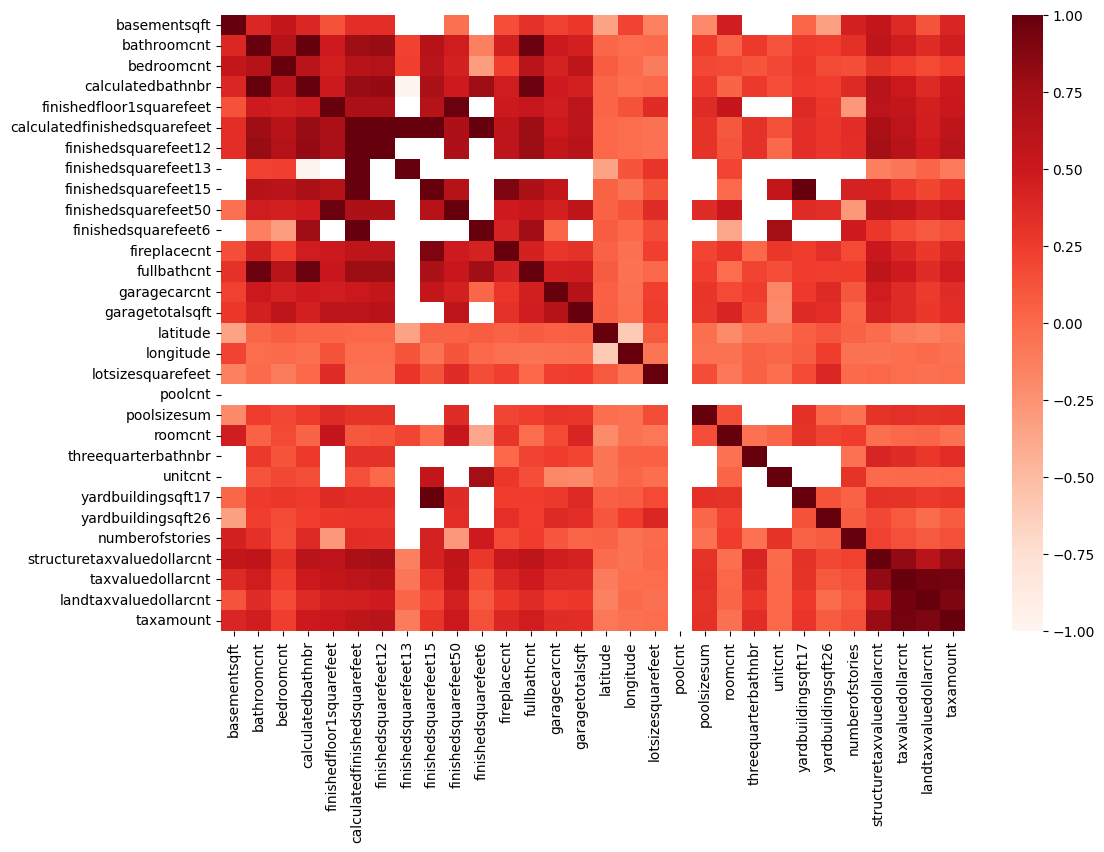

<Figure size 640x480 with 0 Axes>

In [12]:
# Heatmap to visualize correlations between variables
plt.figure(figsize=(12, 8))
sns.heatmap(data=df_prop[numerical_cols].corr(), cmap="Reds")
plt.show()
plt.gcf().clear()

From the analysis of the heatmap on the correlation between the numerical variables, it is noted that the features 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15' and 'finishedsquarefeet6' are highly correlated being dark red in color.
The same consideration also applies to 'finishedfloor1squarefeet' and 'finishedsquarefeet50' which additionally have the same description in the documentation provided.
Similarly 'bathroomcnt', 'calculatedbathnbr' and 'fullbathcnt' are also related.

Only 'calculatedfinishedsquarefeet' is kept among the four because it has fewer missing values, while between 'finishedfloor1squarefeet' and 'finishedsquarefeet50' 'finishedsquarefeet50' is arbitrarily removed because the missing ratio is equivalent.

'bathroomcnt' and 'calculatedbathnbr' are also removed, leaving 'bathroomcnt', as a similar intuition to the previous one is applied

In [13]:
df_prop[
    [
        "calculatedfinishedsquarefeet",
        "finishedsquarefeet12",
        "finishedsquarefeet13",
        "finishedsquarefeet15",
        "finishedsquarefeet6",
    ]
].isna().sum() / df_prop.shape[0] * 100

calculatedfinishedsquarefeet    0.7322
finishedsquarefeet12            5.1831
finishedsquarefeet13           99.9634
finishedsquarefeet15           96.0521
finishedsquarefeet6            99.5336
dtype: float64

In [14]:
df_prop.drop(
    columns=[
        "finishedsquarefeet12",
        "finishedsquarefeet13",
        "finishedsquarefeet15",
        "finishedsquarefeet6",
    ],
    inplace=True,
)

In [15]:
df_prop[
    ["finishedfloor1squarefeet", "finishedsquarefeet50"]
].isna().sum() / df_prop.shape[0] * 100

finishedfloor1squarefeet   92.4054
finishedsquarefeet50       92.4054
dtype: float64

In [16]:
df_prop.drop(columns="finishedsquarefeet50", inplace=True)

In [17]:
df_prop[
    ["calculatedbathnbr", "bathroomcnt", "fullbathcnt"]
].isna().sum() / df_prop.shape[0] * 100

calculatedbathnbr   1.3093
bathroomcnt         0.0000
fullbathcnt         1.3093
dtype: float64

In [18]:
df_prop.drop(columns=["calculatedbathnbr", "fullbathcnt"], inplace=True)

'hashottuborspa' and 'pooltypeid10' have semantically the same description. It is decided to remove 'pooltypeid10' which has fewer missing values.

It is also assumed that if the pool/hot tub value (features 'pooltypeid2', 'pooltypeid7', 'poolcnt') is not present this indicates 0 elements present in the building

In [19]:
print(df_prop["hashottuborspa"].value_counts())
print(df_prop["pooltypeid10"].value_counts())

hashottuborspa
True    2365
Name: count, dtype: int64
pooltypeid10
1.0000    1161
Name: count, dtype: int64


In [20]:
df_prop[["hashottuborspa", "pooltypeid10"]].isnull().sum() / df_prop.shape[0] * 100

hashottuborspa   97.3802
pooltypeid10     98.7139
dtype: float64

In [21]:
df_prop.drop(columns="pooltypeid10", inplace=True)

In [22]:
df_prop[["pooltypeid2", "pooltypeid7", "poolcnt"]] = df_prop[
    ["pooltypeid2", "pooltypeid7", "poolcnt"]
].fillna(0)
df_prop["hashottuborspa"] = df_prop["hashottuborspa"].fillna(0)  # >90% na
df_prop["hashottuborspa"] = df_prop["hashottuborspa"].astype(bool)

For the 'poolsizesum' feature, the median of the values ​​present in the rows where the 'poolcnt' column is greater than 0 is used, otherwise this value is set to 0.

The median was chosen as a filler because it is less influenced by outliers and assumes that the dimensions of swimming pools in the United States are more or less standard.

In [23]:
median_poolsize = df_prop[df_prop["poolcnt"] > 0]["poolsizesum"].median()
df_prop.loc[
    (df_prop["poolcnt"] > 0) & (df_prop["poolsizesum"].isna()), "poolsizesum"
] = median_poolsize

# If you don't have a pool, the pool size is 0
df_prop.loc[(df_prop["poolcnt"] == 0), "poolsizesum"] = 0

'fireplaceflag' and 'fireplacecnt' have inconsistencies:
as you can see from the analysis below there are lines where 'fireplacecnt' is present, while 'fireplaceflag' is missing or incorrect.

The values of 'fireplacecnt' were set to 0 where NaN, and 'fireplaceflag' was set to True when 'fireplacecnt' was present, and False otherwise.

In [24]:
df_prop["fireplaceflag"] = df_prop["fireplaceflag"].fillna(0)  # >90% na
df_prop["fireplaceflag"] = df_prop["fireplaceflag"].astype(bool)
df_prop.loc[(~df_prop["fireplacecnt"].isna()), "fireplaceflag"] = True
df_prop["fireplacecnt"] = df_prop["fireplacecnt"].fillna(0)

The values ​​of 'taxdelinquencyflag', 'garagecarcnt', 'garagetotalsqft' are filled assuming 0 if the value is NaN, as done previously

In [25]:
df_prop[["taxdelinquencyflag", "garagecarcnt", "garagetotalsqft"]] = df_prop[
    ["taxdelinquencyflag", "garagecarcnt", "garagetotalsqft"]
].fillna(0)
df_prop["taxdelinquencyflag"] = df_prop["taxdelinquencyflag"].astype(bool)

Features like 'airconditioningtypeid', 'heatingorsystemtypeid', 'threequarterbathnbr' instead are considered unimportant and variable so it is decided to replace the missing values ​​of these categorical features with their respective mode.<br>
As can be seen from the graphs below, the frequency of these categorical variables is intuitively correct, it is reasonably assumed that AC and Heating System are more commonly 'Central' and that most homes only have a three-quarter bathroom.

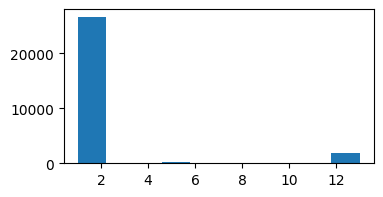

Moda:  1.0


In [26]:
plt.figure(figsize=(4, 2))
df_prop["airconditioningtypeid"].astype(int, errors="ignore").hist(grid=False)
plt.show()

mode = float(df_prop["airconditioningtypeid"].mode()[0])
print("Moda: ", mode)
df_prop["airconditioningtypeid"] = df_prop["airconditioningtypeid"].fillna(mode)

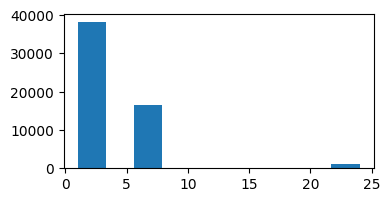

Moda:  2.0


In [27]:
plt.figure(figsize=(4, 2))
df_prop["heatingorsystemtypeid"].astype(int, errors="ignore").hist(grid=False)
plt.show()

mode = float(df_prop["heatingorsystemtypeid"].mode()[0])
print("Moda: ", mode)
df_prop["heatingorsystemtypeid"] = df_prop["heatingorsystemtypeid"].fillna(mode)

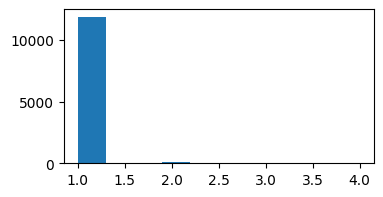

Moda:  1.0


In [28]:
plt.figure(figsize=(4, 2))
df_prop["threequarterbathnbr"].astype(int, errors="ignore").hist(grid=False)
plt.show()

mode = float(df_prop["threequarterbathnbr"].mode()[0])
print("Moda: ", mode)
df_prop["threequarterbathnbr"] = df_prop["threequarterbathnbr"].fillna(mode)

Finally, it was decided to remove the features with a missing ratio greater than 97% because they were considered to have too little information to be useful for the regression task.

In [29]:
tmp_col = df_prop.columns
for c in tmp_col:
    if df_prop[c].isna().sum() / df_prop.shape[0] > 0.97:
        df_prop.drop(columns=c, inplace=True)

In [30]:
tmp_col = df_prop.columns
tmp_list = []

for c in tmp_col:
    if df_prop[c].isna().sum() / df_prop.shape[0] > 0.0:
        tmp_list.append(c)

print("Number of features with missing values: ", len(tmp_list))
print(tmp_list)
print("Number of total features after droping: ", len(df_prop.columns))

Number of features with missing values:  17
['buildingqualitytypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock']
Number of total features after droping:  43


The remaining features are then analyzed, trying to restore the last missing values.

## Missing values imputation

### Geographic location features

In [31]:
geo_col_names = [
    "latitude",
    "longitude",
    "buildingqualitytypeid",
    "propertycountylandusecode",
    "propertyzoningdesc",
    "regionidcity",
    "regionidneighborhood",
    "regionidzip",
    "unitcnt",
    "yearbuilt",
]
df_geo = df_prop[geo_col_names]
df_geo.isna().sum() / df_geo.shape[0] * 100

latitude                     0.0000
longitude                    0.0000
buildingqualitytypeid       36.4564
propertycountylandusecode    0.0011
propertyzoningdesc          35.4052
regionidcity                 1.9972
regionidneighborhood        60.1086
regionidzip                  0.0388
unitcnt                     35.3608
yearbuilt                    0.8374
dtype: float64

Intuitively, given the absence of missing values, the 'latitude' and 'longitude' features relating to the position of the building could be used to recover other attributes that are not present: geographically close houses are in fact thought to have certain similar characteristics<br><br>
The original values ​​of these two features are then restored because, as described in the documentation provided, those within the dataset are multiplied by 10^6.<br>

In [32]:
df_prop["latitude"] = df_prop["latitude"] / (10**6)
df_prop["longitude"] = df_prop["longitude"] / (10**6)
# df_prop.dropna( axis = 0, subset = ['latitude', 'longitude'], inplace = True )

It was decided to use the K-nearest neighbors (KNN) algorithm to perform the recovery task because it was considered the most suitable given that it is based on learning through analogies between neighboring instances and given its computational efficiency. The code cell below also explains the motivations and hypotheses used for the recovery of the categorical and numerical variables

In [33]:
warnings.simplefilter(action="ignore", category=UserWarning)
parameters = {"n_neighbors": [1, 2, 3, 4, 5, 8, 10]}

# It is assumed that blocks of houses close by were all built more or less at the same time and therefore have similar quality.
fillna_knn(
    df=df_prop,
    base=["latitude", "longitude"],
    target="buildingqualitytypeid",
    tuning_params=parameters,
)

# Neighboring homes have the same countrylandusecode
tmp_label_enc = zoningcode2int(df=df_prop, target="propertycountylandusecode")
fillna_knn(
    df=df_prop,
    base=["latitude", "longitude"],
    target="propertycountylandusecode",
    tuning_params=parameters,
)
df_prop["propertycountylandusecode"] = tmp_label_enc.inverse_transform(
    df_prop["propertycountylandusecode"].astype(int)
)


# Neighboring homes have the same zoning description
tmp_label_enc = zoningcode2int(df=df_prop, target="propertyzoningdesc")
fillna_knn(
    df=df_prop,
    base=["latitude", "longitude"],
    target="propertyzoningdesc",
    tuning_params=parameters,
)
df_prop["propertyzoningdesc"] = tmp_label_enc.inverse_transform(
    df_prop["propertyzoningdesc"].astype(int)
)


# Here too, neighboring properties are assumed to have the same regionedcity, regionedneighborhood and regionedzip
fillna_knn(
    df=df_prop,
    base=["latitude", "longitude"],
    target="regionidcity",
    tuning_params=parameters,
)

fillna_knn(
    df=df_prop,
    base=["latitude", "longitude"],
    target="regionidneighborhood",
    tuning_params=parameters,
)

fillna_knn(
    df=df_prop,
    base=["latitude", "longitude"],
    target="regionidzip",
    tuning_params=parameters,
)


# Same intuition for the fields 'unitcnt' (Number of units the structure is built into), 'yearbuilt' and 'lotsizesquarefeet'
fillna_knn(
    df=df_prop,
    base=["latitude", "longitude"],
    target="unitcnt",
    tuning_params=parameters,
)

fillna_knn(
    df=df_prop,
    base=["latitude", "longitude"],
    target="yearbuilt",
    tuning_params=parameters,
)

fillna_knn_reg(
    df=df_prop,
    base=["latitude", "longitude"],
    target="lotsizesquarefeet",
    tuning_params=parameters,
)

warnings.simplefilter(action="default", category=UserWarning)

Target:  buildingqualitytypeid
Best Score: 0.785
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.802
Done!

Target:  propertycountylandusecode
Dealing with variables that are actually string/categories...
num of categories:  (78,)
Target:  propertycountylandusecode
Best Score: 0.770
Best Params:  {'n_neighbors': 2}
Test Accuracy: 0.780
Done!

Target:  propertyzoningdesc
Dealing with variables that are actually string/categories...
num of categories:  (1997,)
Target:  propertyzoningdesc
Best Score: 0.768
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.776
Done!

Target:  regionidcity
Best Score: 0.984
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.984
Done!

Target:  regionidneighborhood
Best Score: 0.969
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.973
Done!

Target:  regionidzip
Best Score: 0.976
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.981
Done!

Target:  unitcnt
Best Score: 0.935
Best Params:  {'n_neighbors': 10}
Test Accuracy: 0.939
Done!

Target:  yearbuilt
Be

Regarding the feature 'finishedfloor1squarefeet,' as evidenced by the heatmap presented at the beginning of this section, it shows a correlation with 'calculatedfinishedsquarefeet.' Therefore, an attempt is made to use the latter to fill in its missing values.

<Figure size 800x800 with 0 Axes>

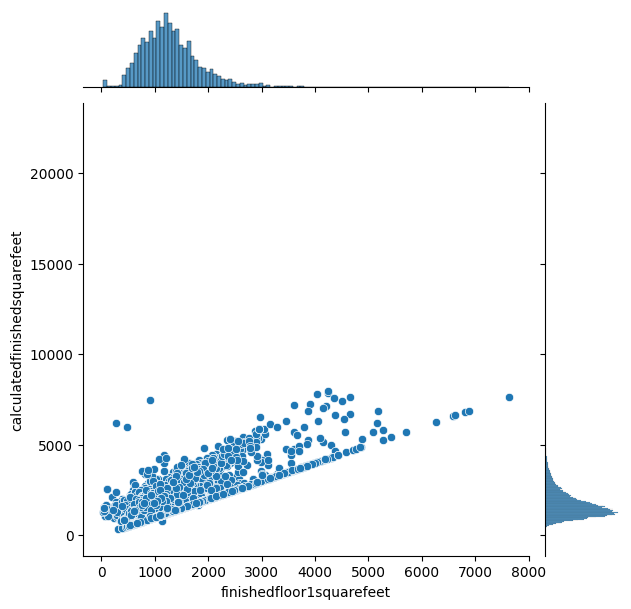

In [34]:
plt.figure(figsize=(8, 8))
sns.jointplot(
    x=df_prop["finishedfloor1squarefeet"].values,
    y=df_prop["calculatedfinishedsquarefeet"].values,
)
plt.ylabel("calculatedfinishedsquarefeet", fontsize=10)
plt.xlabel("finishedfloor1squarefeet", fontsize=10)
#plt.title("finishedfloor1squarefeet Vs calculatedfinishedsquarefeet", fontsize=13)
plt.show()

The plot indicates that for certain houses, the values of the features are identical, suggesting that some properties may consist of a total area occupied by only one room, such as a study. This observation is accepted as valid, and the necessary filling of missing values is conducted accordingly.

Additionally, some rows in the dataset contain values for 'finishedfloor1squarefeet' that exceed the total size of the house, likely due to incorrect data entry. Consequently, it has been decided to remove these rows from the dataset to maintain data integrity.

In [35]:
df_prop.loc[
    (df_prop["finishedfloor1squarefeet"].isna()) & (df_prop["numberofstories"] == 1),
    "finishedfloor1squarefeet",
] = df_prop.loc[
    (df_prop["finishedfloor1squarefeet"].isna()) & (df_prop["numberofstories"] == 1),
    "calculatedfinishedsquarefeet",
]

droprows = df_prop.loc[
    df_prop["calculatedfinishedsquarefeet"] < df_prop["finishedfloor1squarefeet"]
].index
df_prop = df_prop.drop(droprows)

In [36]:
tmp_col = df_prop.columns
tmp_list = []

for c in tmp_col:
    if df_prop[c].isna().sum() / df_prop.shape[0] > 0.0:
        tmp_list.append(c)

print("Number of features with missing values: ", len(tmp_list))
print(tmp_list)

Number of features with missing values:  8
['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock']


### Taxation features

Next, the focus is on handling variables related to building taxes, specifically 'structuretaxvaluedollarcnt', 'taxamount', and 'landtaxvaluedollarcnt'. The variable 'taxvaluedollarcnt' is considered the most significant for supporting this process, as it contains the fewest missing values.

The NaN values ​​of 'taxvaluedollarcnt' are then filled using its median, in order to have a result less sensitive to outliers.

In [37]:
tax_col_names = [
    "taxvaluedollarcnt",
    "landtaxvaluedollarcnt",
    "structuretaxvaluedollarcnt",
    "taxamount",
]
df_tax = df_prop[tax_col_names]
df_tax.isna().sum() / df_tax.shape[0] * 100

taxvaluedollarcnt            0.0011
landtaxvaluedollarcnt        0.0011
structuretaxvaluedollarcnt   0.4209
taxamount                    0.0066
dtype: float64

In [38]:
median = df_prop["taxvaluedollarcnt"].median()
df_prop["taxvaluedollarcnt"] = df_prop["taxvaluedollarcnt"].fillna(median)

From the correlation analysis and distribution graphs for the three target variables, it was observed that 'taxvaluedollarcnt' has the highest correlation with all of them. Therefore, to address missing values, the K-Nearest Neighbors (KNN) algorithm is used to predict the missing values for the features 'structuretaxvaluedollarcnt', 'taxamount', and 'landtaxvaluedollarcnt'.

Target: structuretaxvaluedollarcnt
structuretaxvaluedollarcnt   1.0000
taxvaluedollarcnt            0.8261
taxamount                    0.7950
landtaxvaluedollarcnt        0.6233
Name: structuretaxvaluedollarcnt, dtype: float64


<Figure size 600x600 with 0 Axes>

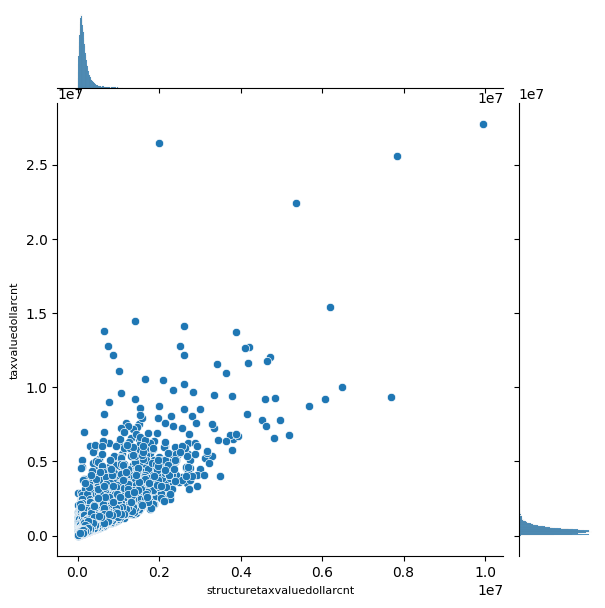

Target: taxamount
taxamount                    1.0000
taxvaluedollarcnt            0.9494
landtaxvaluedollarcnt        0.9027
structuretaxvaluedollarcnt   0.7950
Name: taxamount, dtype: float64


<Figure size 600x600 with 0 Axes>

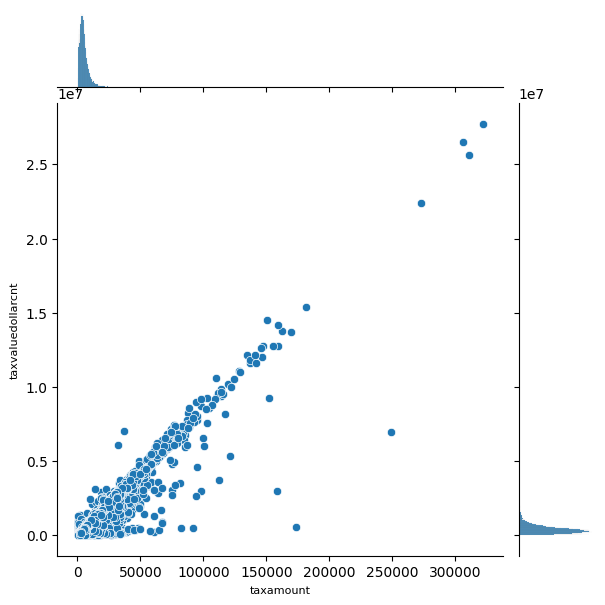

Target: landtaxvaluedollarcnt
landtaxvaluedollarcnt        1.0000
taxvaluedollarcnt            0.9553
taxamount                    0.9027
structuretaxvaluedollarcnt   0.6233
Name: landtaxvaluedollarcnt, dtype: float64


<Figure size 600x600 with 0 Axes>

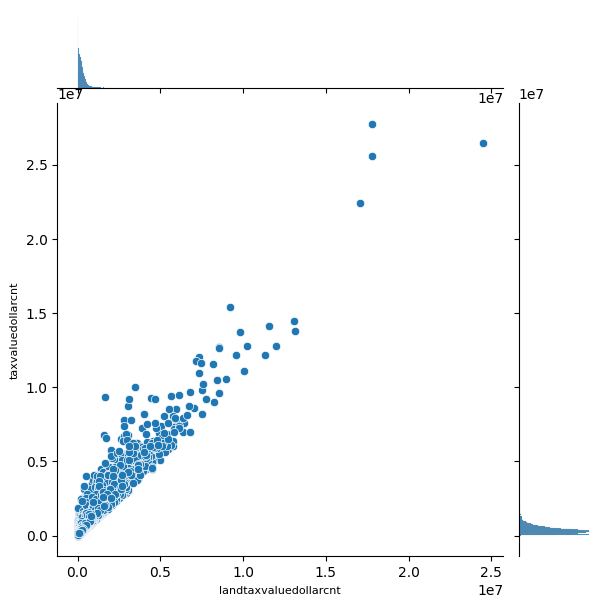

In [39]:
x = df_tax.corr()

print("Target: structuretaxvaluedollarcnt")
print(x["structuretaxvaluedollarcnt"].sort_values(ascending=False))
plt.figure(figsize=(6, 6))
sns.jointplot(
    x=df_tax["structuretaxvaluedollarcnt"].values, y=df_tax["taxvaluedollarcnt"].values
)
plt.ylabel("taxvaluedollarcnt", fontsize=8)
plt.xlabel("structuretaxvaluedollarcnt", fontsize=8)
# plt.title("structuretaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=10)
plt.show()

print("Target: taxamount")
print(x["taxamount"].sort_values(ascending=False))
plt.figure(figsize=(6, 6))
sns.jointplot(x=df_tax["taxamount"].values, y=df_tax["taxvaluedollarcnt"].values)
plt.ylabel("taxvaluedollarcnt", fontsize=8)
plt.xlabel("taxamount", fontsize=8)
# plt.title("taxamount Vs taxvaluedollarcnt", fontsize=10)
plt.show()

print("Target: landtaxvaluedollarcnt")
print(x["landtaxvaluedollarcnt"].sort_values(ascending=False))
plt.figure(figsize=(6, 6))
sns.jointplot(
    x=df_tax["landtaxvaluedollarcnt"].values, y=df_tax["taxvaluedollarcnt"].values
)
plt.ylabel("taxvaluedollarcnt", fontsize=8)
plt.xlabel("landtaxvaluedollarcnt", fontsize=8)
# plt.title("landtaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=10)
plt.show()

In [40]:
parameters = {"n_neighbors": [10, 20, 30, 40, 50, 100]}
fillna_knn_reg(
    df=df_prop,
    base=["taxvaluedollarcnt"],
    target="structuretaxvaluedollarcnt",
    tuning_params=parameters,
)
fillna_knn_reg(
    df=df_prop, base=["taxvaluedollarcnt"], target="taxamount", tuning_params=parameters
)
fillna_knn_reg(
    df=df_prop,
    base=["taxvaluedollarcnt"],
    target="landtaxvaluedollarcnt",
    tuning_params=parameters,
)

Target:  structuretaxvaluedollarcnt
Best Score: 120772.2984
Best Params:  {'n_neighbors': 40}
MSE: 114544.3438
Done!

Target:  taxamount
Best Score: 2201.2908
Best Params:  {'n_neighbors': 10}
MSE: 2958.4644
Done!

Target:  landtaxvaluedollarcnt
Best Score: 132684.3531
Best Params:  {'n_neighbors': 10}
MSE: 118479.8594
Done!



In [41]:
tmp_col = df_prop.columns
tmp_list = []

for c in tmp_col:
    if df_prop[c].isna().sum() / df_prop.shape[0] > 0.0:
        tmp_list.append(c)

print("Number of features with missing values: ", len(tmp_list))
print(tmp_list)

Number of features with missing values:  4
['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'numberofstories', 'censustractandblock']


As observed, only a few features remain with missing values. Therefore, the next step is to address these remaining missing values:
- filling 'numberofstories' with her mode
- removing the 'censustractandblock' column because it is assumed that the 'rawcensustractandblock' attribute contains the same information albeit in a less elaborate way.
- building a predictor for 'calculatedfinishedsquarefeet' based on 'bathroomcnt', 'bedroomcnt', 'structuretaxvaluedollarcnt'. The total size of the living area is assumed to depend on how many bathrooms and bedrooms there are and how much structure tax is attributed to the dwelling.
- building a predictor for 'finishedfloor1squarefeet' based on the same features as above and the number of stories in the building (numberofstories). It is assumed that the number of stories present can be useful to calculate the feature 'finishedfloor1squarefeet' (*Dimensions of the finished living space on the first floor (entrance) of the house*)

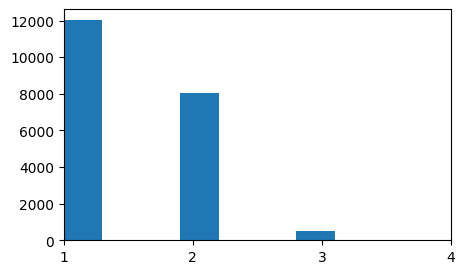

Moda:  1.0


In [42]:
plt.figure(figsize=(5, 3))
x_min = df_prop["numberofstories"].min()
x_max = df_prop["numberofstories"].max()
plt.xlim([x_min, x_max])
plt.xticks(np.arange(x_min, x_max + 1, 1))
df_prop["numberofstories"].hist()
plt.grid()
plt.show()

mode = float(df_prop["numberofstories"].mode()[0])
print("Moda: ", mode)
df_prop["numberofstories"] = df_prop["numberofstories"].fillna(mode)

In [43]:
df_prop.drop(columns="censustractandblock", inplace=True)

In [44]:
fillna_knn_reg(
    df=df_prop,
    base=["bathroomcnt", "bedroomcnt", "structuretaxvaluedollarcnt"],
    target="calculatedfinishedsquarefeet",
    tuning_params=parameters,
)
fillna_knn_reg(
    df=df_prop,
    base=["bathroomcnt", "bedroomcnt", "structuretaxvaluedollarcnt", "numberofstories"],
    target="finishedfloor1squarefeet",
    tuning_params=parameters,
)

Target:  calculatedfinishedsquarefeet
Best Score: 415.2372
Best Params:  {'n_neighbors': 40}
MSE: 412.0274
Done!

Target:  finishedfloor1squarefeet
Best Score: 332.3370
Best Params:  {'n_neighbors': 30}
MSE: 339.1894
Done!



In [45]:
tmp_col = df_prop.columns
tmp_list = []

for c in tmp_col:
    if df_prop[c].isna().sum() / df_prop.shape[0] > 0.0:
        tmp_list.append(c)

print("Number of missing features: ", len(tmp_list))

Number of missing features:  0


In [46]:
print("Columns:")
print(df_prop.columns)
print("Shape: ", df_prop.shape)

Columns:
Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'fips',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories',
       'fireplaceflag', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount',
       'taxdelinquencyflag'],
      dtype='object')
Shape:  (90273, 42)


# Feature engineering

Some custom features are now created and added to the dataset that could intuitively be useful for building the final model and to better explain the data trend.

## Building properties related features

In [47]:
# Age of the building at the time of sale
df_prop["yearbuilt"] = pd.to_datetime(df_prop["yearbuilt"], format="%Y")
df_prop["assessmentyear"] = pd.to_datetime(df_prop["assessmentyear"], format="%Y")
df_prop["Life-until-selling"] = (
    df_prop["transactiondate"] - df_prop["yearbuilt"]
).dt.days

# Relationship between structure value and land area
df_prop["N-ValueProp"] = (
    df_prop["structuretaxvaluedollarcnt"] / df_prop["landtaxvaluedollarcnt"]
)

# Portion of livable area
df_prop["N-LivingAreaProp"] = (
    df_prop["calculatedfinishedsquarefeet"] / df_prop["lotsizesquarefeet"]
)

# Amount of extra space
df_prop["N-ExtraSpace"] = (
    df_prop["lotsizesquarefeet"] - df_prop["calculatedfinishedsquarefeet"]
)

# Features that indicate whether the property has a garage, pool, or jacuzzi and AC
df_prop["N-GarPoolAC"] = (
    (df_prop["garagecarcnt"] > 0)
    & (df_prop["hashottuborspa"] > 0)
    & (df_prop["airconditioningtypeid"] != 5)
) * 1
df_prop["N-GarPoolAC"] = df_prop["N-GarPoolAC"].astype(bool)

In [48]:
# Home Tax to Total Tax Ratio by Assessment Year
df_prop["N-ValueRatio"] = df_prop["taxvaluedollarcnt"] / df_prop["taxamount"]

# Total Tax Score
df_prop["N-TaxScore"] = df_prop["taxvaluedollarcnt"] * df_prop["taxamount"]

## Location-related features

In [49]:
# Number of properties per zip code
zip_count = df_prop["regionidzip"].value_counts().to_dict()
df_prop["N-zip_count"] = df_prop["regionidzip"].map(zip_count)

# Number of properties per city
city_count = df_prop["regionidcity"].value_counts().to_dict()
df_prop["N-city_count"] = df_prop["regionidcity"].map(city_count)

# Number of properties per country
region_count = df_prop["regionidcounty"].value_counts().to_dict()
df_prop["N-county_count"] = df_prop["regionidcounty"].map(region_count)

## Features that simplify other features

In [50]:
# Indicator whether AC is present or not
df_prop["N-ACInd"] = (df_prop["airconditioningtypeid"] != 5) * 1
df_prop["N-ACInd"] = df_prop["N-ACInd"].astype(bool)

# Indicator whether heating is present or not
df_prop["N-HeatInd"] = (df_prop["heatingorsystemtypeid"] != 13) * 1
df_prop["N-HeatInd"] = df_prop["N-HeatInd"].astype(bool)

# Type of land use for which the property is zoned - previously there were 25 categories, now they are compressed to 4
df_prop["N-PropType"] = df_prop["propertylandusetypeid"].replace(
    {
        31: "Mixed",
        46: "Other",
        47: "Mixed",
        246: "Mixed",
        247: "Mixed",
        248: "Mixed",
        260: "Home",
        261: "Home",
        262: "Home",
        263: "Home",
        264: "Home",
        265: "Home",
        266: "Home",
        267: "Home",
        268: "Home",
        269: "Not Built",
        270: "Home",
        271: "Home",
        273: "Home",
        274: "Other",
        275: "Home",
        276: "Home",
        279: "Home",
        290: "Not Built",
        291: "Not Built",
    }
)
df_prop.drop(columns="propertylandusetypeid", inplace=True)

## Features related to 'structuretaxvaluedollarcnt'
'structuretaxvaluedollarcnt' it is considered an important specification

In [51]:
# Average structuretaxvaluedollarct per city
group = (
    df_prop.groupby("regionidcity")["structuretaxvaluedollarcnt"]
    .aggregate("mean")
    .to_dict()
)
df_prop["N-Avg-structuretaxvaluedollarcnt"] = df_prop["regionidcity"].map(
    group
)  # assign 'regionidcity' to the mean calculated above and put into a dictionary with key 'regionidcity'

# Deviation of the value from the mean
df_prop["N-Dev-structuretaxvaluedollarcnt"] = (
    abs(
        (
            df_prop["structuretaxvaluedollarcnt"]
            - df_prop["N-Avg-structuretaxvaluedollarcnt"]
        )
    )
    / df_prop["N-Avg-structuretaxvaluedollarcnt"]
)

In [52]:
# In case there are "Infinity" values ​​in the dataset resulting from divisions by zero, these are set to 0 as it is semantically correct.
df_prop.replace([np.inf, -np.inf], 0, inplace=True)

In [53]:
df_prop.info(max_cols=TOP_K_DISPLAY)
print("Shape: ", df_prop.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 90273 entries, 0 to 90274
Columns: 56 entries, parcelid to N-Dev-structuretaxvaluedollarcnt
dtypes: bool(6), datetime64[ns](3), float32(37), float64(2), int64(5), object(3)
memory usage: 22.9+ MB
Shape:  (90273, 56)


# Feature selection


At this point the dataset no longer has missing values ​​and intuitively the multicollinearity problems between the input features, highlighted in the previous analyses, have been resolved. The feature selection process can then be carried out in order to build even more accurate forecasting models.

In [54]:
cat_var_names = set(
    [
        "airconditioningtypeid",
        "heatingorsystemtypeid",
        "propertycountylandusecode",
        "N-PropType",
        "propertyzoningdesc",
        "regionidcity",
        "regionidcounty",
        "regionidneighborhood",
        "regionidzip",
        "fips",
        "rawcensustractandblock",
    ]
)

for c in cat_var_names:
    print(c, len(df_prop[c].unique()))

regionidzip 388
heatingorsystemtypeid 12
regionidcounty 3
propertycountylandusecode 77
propertyzoningdesc 1996
regionidcity 177
airconditioningtypeid 6
N-PropType 3
regionidneighborhood 494
fips 3
rawcensustractandblock 470


However, it is decided to remove some of the categorical variables with many distinct elements (specifically 'propertyzoningdesc', 'propertycountylandusecode', 'regionidneighborhood', 'regionidzip', 'regionidcity', 'rawcensustractandblock') so as not to exponentially increase the size of the matrix after the OneHotEncoding process (also possible curse of dimensionality problem) and increase the time required for training and testing the models.<br>
Please note that this encoding process is necessary for the correct management of categorical features, otherwise they would be interpreted in a numerical or ordinal way.

In [55]:
removed_cat = set(
    [
        "propertyzoningdesc",
        "propertycountylandusecode",
        "regionidneighborhood",
        "regionidzip",
        "regionidcity",
        "rawcensustractandblock",
    ]
)
one_hot_colmuns = list(cat_var_names.difference(removed_cat))


one_hot_enc = OneHotEncoder(sparse_output=False)
one_hot_enc.fit(df_prop[one_hot_colmuns])
one_hot_tranform_name = one_hot_enc.get_feature_names_out(one_hot_colmuns)

df_one_hot = pd.DataFrame(
    one_hot_enc.transform(df_prop[one_hot_colmuns]), columns=one_hot_tranform_name  # type: ignore
)

df_prop_drop_cat = df_prop.drop(columns=list(cat_var_names))
df_prop_final = pd.concat(
    [df_prop_drop_cat.reset_index(), df_one_hot.reset_index()], axis=1
)
df_prop_final.drop(columns=["index"], inplace=True)


# Convert date to integer
df_prop_final["yearbuilt"] = df_prop_final["yearbuilt"].dt.year
df_prop_final["assessmentyear"] = df_prop_final["assessmentyear"].dt.year
to_float64_float32(df_prop_final)
to_int64_int32(df_prop_final)
del df_prop, df_one_hot

In [56]:
df_prop_final.info(max_cols=TOP_K_DISPLAY)
print("Final shape: ", df_prop_final.shape)
df_prop_final.to_parquet(os.path.join(OUTPUT_DATA_DIR, "final_df.parquet"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90273 entries, 0 to 90272
Columns: 72 entries, parcelid to fips_6111.0
dtypes: bool(6), datetime64[ns](1), float32(58), int32(7)
memory usage: 23.6 MB
Final shape:  (90273, 72)


In [57]:
X = df_prop_final.drop(columns=["parcelid", "logerror", "transactiondate"])
y = df_prop_final["logerror"]

X and y will contain respectively:
- the features to use for building the model
- the actual values ​​to be used for the supervised learning task

*Please note that the variables only contain data of type float (or convertible to float) because these are the only types accepted by the ML algorithms used*

In the following section, the tuning of the "n_estimators" parameter is performed to build a model using gradient boosting. Once trained, this model will be used to identify the features that have the greatest impact according to the algorithm. The XGBoost library was selected for this task due to its high efficiency and accuracy in handling complex datasets and delivering reliable results.

In [58]:
tuning_params = {"n_estimators": [i for i in range(1, 30, 1)]}

X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, test_size=0.20)

xgb_model = xgb.XGBRegressor()
xgb_grid = RandomizedSearchCV(
    estimator=xgb_model,
    n_iter=RANDOM_SEARCH_ITER,
    param_distributions=tuning_params,
    cv=CV_ITER,
    scoring="neg_root_mean_squared_error",
    verbose=0,
    n_jobs=-1,
)

print("Tuning XGBoost hyperparameters:")
xgb_grid.fit(X_train_80, y_train_80)
print("Best Score: {:.4f}".format(-xgb_grid.best_score_))
print("Best Params: ", xgb_grid.best_params_)

test_mse = root_mean_squared_error(y_true=y_test, y_pred=xgb_grid.predict(X_test))
print("MSE: {:.4f}".format(test_mse))

Tuning XGBoost hyperparameters:
Best Score: 0.1596
Best Params:  {'n_estimators': 4}
MSE: 0.1645


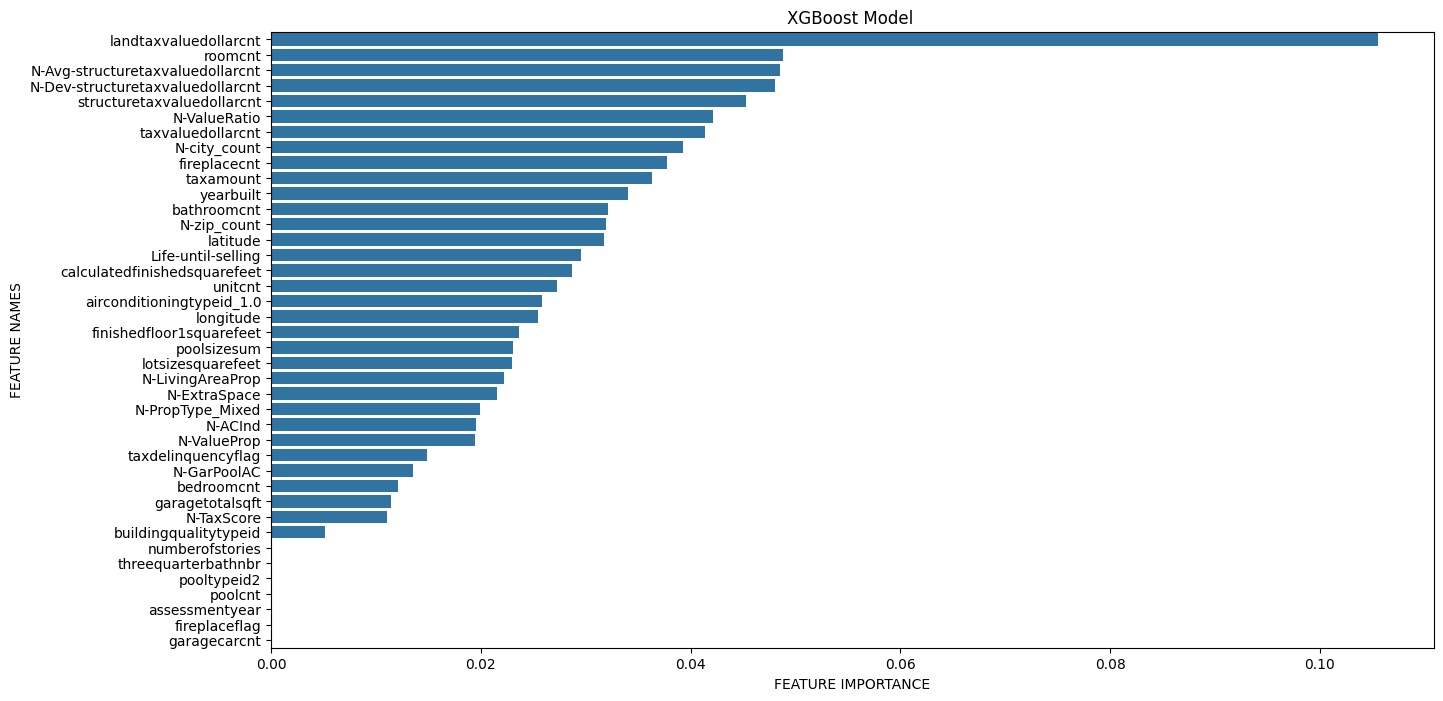

In [59]:
plot_feature_importance(
    xgb_grid.best_estimator_.feature_importances_, X.columns, "XGBoost Model ", limit=40
)

The graph illustrating feature importance indicates that many of the custom variables added earlier play a significant role in the model's construction.

The presumed best subset of n features is now chosen using the subsequent feature ranking method with recursive feature elimination using cross-validation sets in order to reduce, as anticipated, the dimensionality of the data frame and the consequent problems of multicollinearity and curse of dimensionality to further optimize the predictions.<br>
It was decided to set a minimum number of 10 features so that the final model does not have too few variables that would consequently not be able to explain the data accurately enough.

In [60]:
selector = RFECV(
    xgb_grid.best_estimator_,
    step=1,
    cv=CV_ITER,
    scoring="neg_root_mean_squared_error",
    min_features_to_select=10,
    n_jobs=-1,
)
selector.fit(X, y);

The features selected by the algorithm are specifically:

In [61]:
list_important_features = [
    x[0] for x in list(zip(X.columns, selector.support_)) if x[1]
]
print("Number of important features: ", selector.n_features_)
print("Important features:")
for i, f in enumerate(list_important_features):
    print(f, end=", " if i != len(list_important_features) - 1 else "")
    if i != 0 and (i + 1) % 3 == 0:
        print()

Number of important features:  14
Important features:
bathroomcnt, finishedfloor1squarefeet, calculatedfinishedsquarefeet, 
garagetotalsqft, poolcnt, yearbuilt, 
taxamount, Life-until-selling, N-LivingAreaProp, 
N-ValueRatio, N-TaxScore, N-city_count, 
N-Avg-structuretaxvaluedollarcnt, N-Dev-structuretaxvaluedollarcnt

The dataset containing the selected features is created and saved offline so that it can then be used for the construction of the two final models or for any future analyses.

In [62]:
selected_important_X = X[list_important_features]
selected_important_X.shape

(90273, 14)

In [63]:
selected_important_X.to_parquet(
    os.path.join(OUTPUT_DATA_DIR, "final_df_filtered.parquet")
)

# Models implementation

## Random forest

At this stage it was decided to implement parameter tuning in a more sophisticated way.
Specifically, the method with cross validation sets will search for the best combination of "n_estimators", "max_leaf_nodes" and "min_samples_leaf", 3 of the main hyperparameters for the construction of the regressor using the Random Forest ensembling method.

In [64]:
X_train_80, X_test, y_train_80, y_test = train_test_split(
    selected_important_X, y, test_size=0.20
)

In [65]:
tuning_params = {
    "n_estimators": [i for i in range(10, 101, 10)],
    "max_leaf_nodes": [
        10,
        30,
        50,
        100,
        200,
    ],  # Grow trees with max_leaf_nodes in best-first fashion
    "min_samples_leaf": [i for i in range(1, 5, 1)],
}  # The minimum number of samples required to be at a leaf node.

rf = RandomForestRegressor()
rf_model = RandomizedSearchCV(
    estimator=rf,
    n_iter=RANDOM_SEARCH_ITER,
    param_distributions=tuning_params,
    cv=CV_ITER,
    scoring="neg_root_mean_squared_error",
    verbose=0,
    n_jobs=-1,
)

print("Tuning Random Forest hyperparameters:")
rf_model.fit(X_train_80, y_train_80)
print("Best Score: {:.4f}".format(-rf_model.best_score_))
print("Best Params: ", rf_model.best_params_)

test_mse = root_mean_squared_error(y_true=y_test, y_pred=rf_model.predict(X_test))
print("MSE: {:.4f}".format(test_mse))

joblib.dump(rf_model, os.path.join(MODEL_DIR, "random_forest_model.pkl"));

Tuning Random Forest hyperparameters:
Best Score: 0.1606
Best Params:  {'n_estimators': 50, 'min_samples_leaf': 2, 'max_leaf_nodes': 30}
MSE: 0.1596


It is believed that the Mean Squared Error values ​​obtained, especially in the testing set, are sufficiently low and that consequently the model using Random Forest is quite accurate. Furthermore, using cross validation sets has limited the possibility of overfitting of the predictor

## Gradient boosting tree

Even for the construction of this model it was decided to perform a more sophisticated tuning of the parameters.
Specifically, the method with cross validation sets will search for the best combination of "n_estimators", "max_leaves" and "learning_rate", 3 of the main hyperparameters for the construction of the regressor using the Gradient Boosting method.

In [67]:
X_train_80, X_test, y_train_80, y_test = train_test_split(
    selected_important_X, y, test_size=0.20
)

In [68]:
tuning_params = {
    "n_estimators": [i for i in range(10, 101, 10)],
    "max_leaves": [
        2,
        5,
        10,
        50,
        100,
        200,
    ],  # Maximum number of leaves; 0 indicates no limit
    "learning_rate": [0.1, 0.2, 0.3, 0.4],
}  # Boosting learning rate (xgb's “eta”).
# Step size shrinkage used in update to prevents overfitting. The value must be between 0 and 1. Default is 0.3.

xgb_m = xgb.XGBRegressor()
xgb_model = RandomizedSearchCV(
    estimator=xgb_m,
    n_iter=RANDOM_SEARCH_ITER,
    param_distributions=tuning_params,
    cv=CV_ITER,
    scoring="neg_root_mean_squared_error",
    verbose=0,
    n_jobs=-1,
)

print("Tuning XGBoost hyperparameters:")
xgb_model.fit(X_train_80, y_train_80)
print("Best Score: {:.4f}".format(-xgb_model.best_score_))
print("Best Params: ", xgb_model.best_params_)

test_mse = root_mean_squared_error(y_true=y_test, y_pred=xgb_model.predict(X_test))
print("MSE: {:.4f}".format(test_mse))

joblib.dump(xgb_model, os.path.join(MODEL_DIR, "xgboost_model.pkl"));

Tuning XGBoost hyperparameters:
Best Score: 0.1620
Best Params:  {'n_estimators': 60, 'max_leaves': 5, 'learning_rate': 0.1}
MSE: 0.1537


Also in this case it is believed that the Mean Squared Error values ​​obtained, in particular in the testing set, are sufficiently low and that consequently the model based on Gradient Boosting is quite accurate. Furthermore, using the cross validation sets has limited the possibility of overfitting in the regressor

# Models comparison

Once the construction of the final statistical models has been completed, the next step involves a more in-depth analysis of their behavior. This analysis will specifically focus on a selection of buildings with the highest log errors as well as those with the lowest log errors, allowing for a comprehensive evaluation of model performance.

The buildings with log error between the most extreme value and the most extreme value minus 1 are then extracted (worst items) and ten of the buildings where the log error is zero (best items).

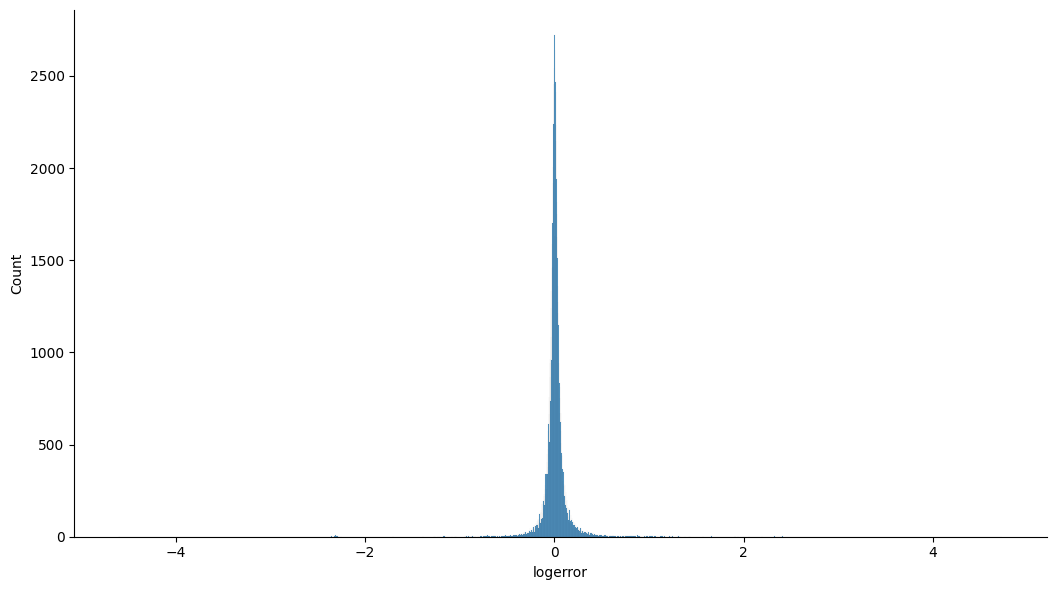

In [70]:
sns.displot(df_prop_final, x="logerror", height=6, aspect=16 / 9)

The variable 'logerror' follows a normal distribution

In [71]:
offset = 1
max_error_pos = df_prop_final["logerror"].max() - offset
max_error_neg = df_prop_final["logerror"].min() + offset

worst_items = pd.concat(
    [
        df_prop_final[df_prop_final["logerror"] >= max_error_pos],
        df_prop_final[df_prop_final["logerror"] <= max_error_neg],
    ]
)
best_items = df_prop_final[df_prop_final["logerror"] == 0].head(10)

In [72]:
worst_items_X = selected_important_X.iloc[worst_items.index]
worst_items_X

,bathroomcnt,finishedfloor1squarefeet,calculatedfinishedsquarefeet,garagetotalsqft,poolcnt,yearbuilt,taxamount,Life-until-selling,N-LivingAreaProp,N-ValueRatio,N-TaxScore,N-city_count,N-Avg-structuretaxvaluedollarcnt,N-Dev-structuretaxvaluedollarcnt
7318,3.0000,3061.4333,2640.0000,0.0000,0.0000,2005,28355.0996,4050,0.0571,80.7564,64929067008.0000,20639,190910.1875,2.7399
8612,2.0000,2130.5000,1795.0000,0.0000,1.0000,2006,13866.8398,3692,0.0567,81.2781,15628899328.0000,20639,190910.1875,1.5976
22475,3.0000,2696.6667,3179.0000,0.0000,0.0000,1962,12303.6904,19818,0.1432,86.4810,13091569664.0000,776,228240.5781,0.5089
22476,3.0000,5217.4331,3142.0000,0.0000,0.0000,1962,28388.4609,19818,0.1440,87.6673,70651494400.0000,776,228240.5781,8.8878
6416,1.0000,1259.1000,985.0000,0.0000,1.0000,1952,3821.8101,23404,0.1742,75.6736,1105305728.0000,294,95555.1250,0.3947
69226,2.5000,943.0000,1843.0000,427.0000,0.0000,1999,4274.1201,6445,0.3435,85.9201,1569597952.0000,1265,195516.0312,0.1340
88786,2.0000,1525.8667,1417.0000,0.0000,0.0000,1940,8238.6797,28098,0.2234,81.1857,5510547968.0000,20639,190910.1875,0.2993


In [73]:
best_items_X = selected_important_X.iloc[best_items.index]
best_items_X

,bathroomcnt,finishedfloor1squarefeet,calculatedfinishedsquarefeet,garagetotalsqft,poolcnt,yearbuilt,taxamount,Life-until-selling,N-LivingAreaProp,N-ValueRatio,N-TaxScore,N-city_count,N-Avg-structuretaxvaluedollarcnt,N-Dev-structuretaxvaluedollarcnt
64,2.0000,1323.2667,1344.0000,0.0000,0.0000,1979,4727.7798,13517,0.0837,88.4476,1976973184.0000,1857,131894.7344,0.0132
143,2.0000,1214.0000,1214.0000,483.0000,0.0000,1958,5453.8999,21187,0.1823,10.2635,305287488.0000,1039,137692.9375,0.7462
223,1.0000,1104.6333,1289.0000,0.0000,0.0000,1952,6527.6401,23379,0.2362,76.1277,3243806208.0000,654,100058.2734,0.3568
339,2.0000,1586.6666,1601.0000,0.0000,0.0000,1947,4347.3599,25206,0.2605,56.4402,1066694272.0000,590,84280.2031,1.1765
655,3.0000,3112.0000,3112.0000,0.0000,1.0000,1961,19705.1992,20093,0.0755,89.9854,34940866560.0000,250,247524.7812,3.7048
694,1.0000,941.7000,1036.0000,0.0000,0.0000,1955,3802.5400,22285,0.1276,9.6425,139423936.0000,757,116326.7188,0.7863
826,2.0000,1341.4000,930.0000,0.0000,0.0000,1988,2590.5601,10232,0.0030,78.9424,529782496.0000,757,116326.7188,0.0408
833,2.5000,1798.8334,1374.0000,0.0000,0.0000,1990,5073.4399,9501,0.2748,90.2741,2323635456.0000,1857,131894.7344,0.0310
870,1.0000,990.0333,792.0000,0.0000,0.0000,1928,7093.6602,32147,0.4166,81.7158,4111939328.0000,20639,190910.1875,0.3339
1123,2.0000,1718.3000,2062.0000,0.0000,0.0000,1965,3355.6599,18633,0.2304,66.1569,744956480.0000,2038,128245.1875,0.3919


Text(0.5, 1.0, 'Log-errors comparisons - Worst items')

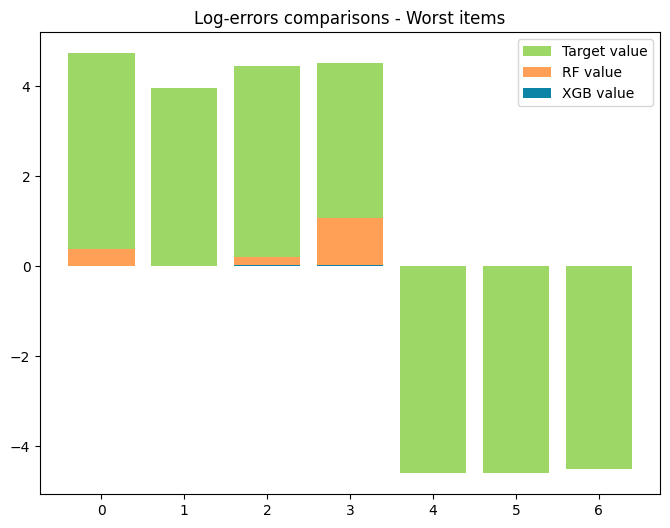

In [74]:
plt.figure(figsize=(8, 6))
plt.bar(
    range(len(worst_items)),
    worst_items["logerror"],
    color=["#9dd866"],
    label="Target value",
)
plt.bar(
    range(len(worst_items)),
    rf_model.predict(worst_items_X),
    color=["#ffa056"],
    label="RF value",
)
plt.bar(
    range(len(worst_items)),
    xgb_model.predict(worst_items_X),
    color=["#0b84a5"],
    label="XGB value",
)
plt.legend()
plt.title("Log-errors comparisons - Worst items")

From the bar chart of the predictions on problematic items, it can be noted that the estimates of the two final models created are very far from the target value calculated by the Zestimate estimator, even if Random forest perform a bit better on these items. This is probably due to the presence of many missing or outlier values, treated with analysis, recovery and correction techniques different from those used by the Zestimate's team.
However, it is hypothesized that items with a high absolute log error may present anomalies or non-standard values ​​for some features, since the competition estimator itself returns predicted values ​​that are quite distant from the real log (remember that $logerror=log(Zestimate)−log(SalePrice)$).

To verify these details, it is thought that it is necessary to contact experts in the field of Data Science, the Zestimate team and real estate technicians.

Text(0.5, 1.0, 'Log-errors comparisons - Best Items')

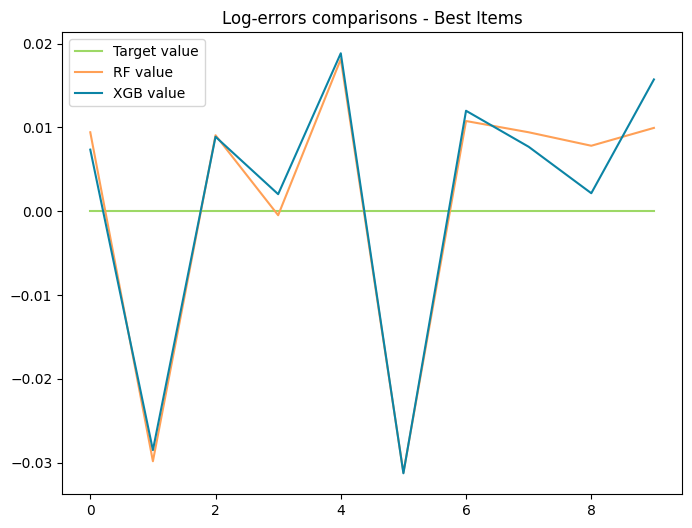

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(
    range(len(best_items)),
    best_items["logerror"],
    color="#9dd866",
    label="Target value",
)
plt.plot(
    range(len(best_items)),
    rf_model.predict(best_items_X),
    color="#ffa056",
    label="RF value",
)
plt.plot(
    range(len(best_items)),
    xgb_model.predict(best_items_X),
    color="#0b84a5",
    label="XGB value",
)
plt.legend()
plt.title("Log-errors comparisons - Best Items")

In the line chart relating to the forecasts on items whose log error is zero, the two models created also return satisfactory values: in fact, the deviation from the target value of Zestimate is in the order of cents.

In general, even in the graphs relating to best items and worst items, no big differences in terms of accuracy are noted between the model with Random Forest and the one with Gradient Boosting tree, even if the MSE value obtained in the testing set of the second model is slightly lower than the one returned by the second.

# Conclusions

The various steps carried out are then briefly summarized:
- Dataset analysis, feature engineering and missing value management
- Features selection and model construction
- Analysis and comparison of the obtained models

In conclusion, thanks to this task it was possible to test on a real, extended and complex dataset, the performances of some Machine Learning methods such as Random Forest and Gradient Boosting tree, both exploiting decision trees but using different intuitions.<br>
However, as previously mentioned, there is not enough evidence to prefer one model over the other since both return accurate and efficient predictions and the deviation in the value of the evaluation metric for the testing set is very low.
Generally, predictors that use the Gradient Boosting technique perform better than those that exploit Random Forest by definition since they have as their objective the minimization of a loss function and the characteristic of additively building the various trees, even if they are more prone to overfitting.<br>
Probably, with a deeper knowledge of the data, of their meaning, of their real trend and with the addition of external information to the dataset it is possible to obtain even more precise results and to build the optimal regression model.

*Summary table containing the evaluation data*
| Set type | Model | MSE Score |
| --- | --- | --- |
| Validation Sets | Random Forest | 0.1606 |
| Validation Sets | Gradient Boosting tree | 0.1620 |
| Testing Set | Random Forest | 0.1596 |
| Testing Set | Gradient Boosting tree | 0.1537 |